# **1. Read + Clean data**

In [1]:
import os
os.chdir("AIO2024/AIO2024/Module_3/Week_4")
os.getcwd()

'd:\\QuocAnh\\AIO\\AIO2024\\AIO2024\\Module_3\\Week_4'

In [16]:
import pandas as pd 

df = pd.read_csv("IMDB-Dataset.csv")
shape_1 = df.shape
df = df.drop_duplicates()
shape_2 = df.shape
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
print(shape_1, shape_2)

(50000, 2) (49582, 2)


In [18]:
import re
import string
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words("english"))

# Expanding contractions. Eg: you're -> you are 
def expand_contractions(text):
    return contractions.fix(text)

# Clean data
def preprocess_text(text):
    word_lem = WordNetLemmatizer()
    soup = BeautifulSoup(markup=text, features="html.parser")  # remove html tags
    
    text = soup.get_text()
    text = expand_contractions(text) 
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"  # other symbols
                             u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r"", text)
    text = re.sub(r"\.(?=\S)", ". ", text)  # add space after full stop
    text = re.sub(r"http\S+", "", text)  # remove urls
    text = "".join([
        word.lower() for word in text if word not in string.punctuation
    ])  # remove punctuation and convert to lowercase
    text = " ".join([
        word_lem.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ])  # lemmatize
    return text

df["review"] = df["review"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Computer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Computer\AppData\Local\Temp\ipykernel_14244\3929797077.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(markup=text, features="html.parser")  # remove html tags


In [19]:
# Create a set to store unique words (vocabulary)
vocabulary = set()

# Populate the vocabulary set with words from each processed review
df["review"].str.split().apply(vocabulary.update)

# Print vocabulary size
print("Vocabulary size:", len(vocabulary))

Vocabulary size: 143180


In [5]:
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


# **2. Data analysis**

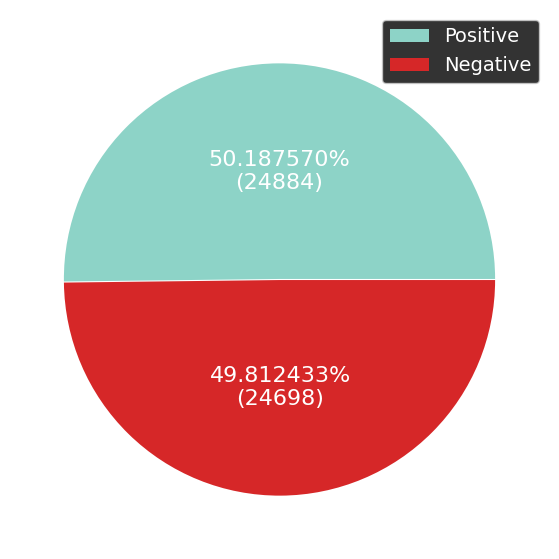

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

# Create autopct arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df["sentiment"] == "positive"])
freq_neg = len(df[df["sentiment"] == "negative"])

data = [freq_pos, freq_neg]
labels = [r"Positive", r"Negative"]

# Create pie chart
pie, ax = plt.subplots(figsize=(11, 7))
pie.patch.set_color("white")
ax.set_facecolor("white")
plt.pie(x=data, 
        autopct=lambda pct: func(pct, data), 
        explode=[0.0025]*2, 
        pctdistance=0.5, 
        colors=[sns.color_palette()[0], "tab:red"],
        textprops={"fontsize": 16})
plt.legend(labels, loc="best", prop={"size": 14})
plt.savefig("pie_chart.png")
plt.show()

# **4. Split train/test**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(df["sentiment"])
x_data = df["review"]

X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# **5. Convert text to vector**

In [12]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train, y_train)

X_train_encoded = tfidf_vectorizer.transform(X_train)
X_test_encoded = tfidf_vectorizer.transform(X_test)

# **6. Train**

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion="entropy",
    random_state=42
)
dt_classifier.fit(X_train_encoded, y_train)
y_pred = dt_classifier.predict(X_test_encoded)
accuracy_score(y_pred, y_test)

0.7140264192800242

In [14]:
rf_classifier = RandomForestClassifier(
    random_state=42
)

rf_classifier.fit(X_train_encoded, y_train)
y_pred = rf_classifier.predict(X_test_encoded)
accuracy_score(y_pred, y_test)

0.8485429061208026